In [57]:
import psycopg2 as pg
import pandas.io.sql as psql
from datetime import datetime
import json

conn_str = "host={0} port={1} dbname={2} user={3} password={4}" \
.format("localhost", 5432, "kanjidb", "postgres", "w0lfpack")

try:
    conn = pg.connect(conn_str)
    print("Welcome to Jupyter Notebook.  You are connected to the Kanji database!")
except pg.OperationalError:
    print("You are not connected to the database.")

Welcome to Jupyter Notebook.  You are connected to the Kanji database!


In [58]:
_STATUS_ONLINE = 10001
_DEPLOY_STATE_MAINTENANCE = 10002
_REPORT_INTERVAL_MINS = 560

In [59]:
#now = datetime.datetime.now()
#timestart = now - datetime.timedelta(hours=1, minutes=15)
#querytime = timestart.strftime("%Y/%m/%d %H:%M:%S")
#print("report period {0} - {1}".format(timestart, now))

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def isint(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

def pinindex(pinnums, k):
    for i in range(len(pinnums)):
        if pinnums[i]==k:
            return i
    return -1   

query = "SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE eventlog.timestamp>= NOW() - INTERVAL '{0} minutes' \
AND (eventlog.node_id=10020)".format(_REPORT_INTERVAL_MINS) 

print(query)

#print("Today is {0}".format(now))
cur = conn.cursor()
cur.execute(query)
rows = cur.fetchall()
if len(rows) > 0:
    timedata = []
    dsetsbuilt = False
    dsets = []
    labels = []
    pinnums = []
    print("The query returned {0} rows.".format(len(rows))) 
    for row in rows:
        #print(row)
        #timestamp = row[0].strftime("%m/%d/%Y %H:%M:%S")
        timestamp = row[0]
        pins = json.loads(row[1])
        if dsetsbuilt == False:
          print("There are {0} pins from this node.".format(len(pins)))
          for i in range(len(pins)):
             pintype = pins[i]['t']
             dset = []
             dsets.append(dset)
             pinnums.append(pintype)
             labelquery = "SELECT description FROM kanji_sensortype WHERE idsensortype={0}".format(pintype)
             cur = conn.cursor()
             cur.execute(labelquery)
             label = cur.fetchone()[0]
             labels.append(label)
          print(pinnums)
          dsetsbuilt = True
        tstamp = False
        for pin in pins:
            if tstamp==False:
              timedata.append(timestamp)
              tstamp=True
            pintype = pin['t']
            pidx = pinindex(pinnums,pintype)
            pinvalue = pin['v']
            if isfloat(pinvalue):
              #print("{0} {1}".format(timestamp, pinvalue))
              dsets[pidx].append(float(pinvalue))
            elif isint(pinvalue):
              dsets[pidx].append(int(pinvalue))
            else:
              dsets[pidx].append(pinvalue)
    print(len(timedata))
    #for dset in dsets:
    #  print(dset)
    
else:
    print("The query returned empty.")
    

SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE eventlog.timestamp>= NOW() - INTERVAL '560 minutes' AND (eventlog.node_id=10020)
The query returned 1077 rows.
There are 5 pins from this node.
[31, 29, 34, 32, 33]
1077


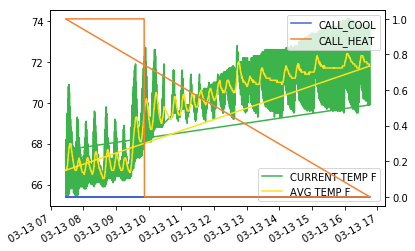

In [60]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

t = np.array(timedata)  

fig, ax = plt.subplots()
plt.plot(t, dsets[1], colors[1], label=labels[1]) 
plt.plot(t, dsets[2], colors[2], label=labels[2]) 
plt.legend()
ax.tick_params('vals', colors='r')

# Get second axis
ax2 = ax.twinx()
plt.plot(t, dsets[3], colors[3], label=labels[3]) 
plt.plot(t, dsets[4], colors[4], label=labels[4]) 
plt.legend()
fig.autofmt_xdate()
plt.show()